## XAI Project : 
## SHAP vs Counterfactual Explanations Of Diabetes Prediction

## Training : Random Forest Classifier

In [1]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline


df = pd.read_csv("/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv")


df = df.drop_duplicates()


df = df[df['gender'] != 'Other']


def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        ('cat', OneHotEncoder(), ['gender','smoking_history'])
    ])

X = df.drop('diabetes', axis=1)
y = df['diabetes']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

clf = imbPipeline(steps=[('preprocessor', preprocessor),
                      ('over', over),
                      ('under', under),
                      ('classifier', RandomForestClassifier(random_state=42))]) # Added random_state for reproducibility



param_grid = {
     'classifier__n_estimators': [50, 100, 200],
     'classifier__max_depth': [None, 10, 20],
     'classifier__min_samples_split': [2, 5, 10],
     'classifier__min_samples_leaf': [1, 2, 4]
 }

param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}



grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=1, scoring='accuracy') 

print("Starting model training (GridSearchCV)...")
grid_search.fit(X_train, y_train)


print("Best Parameters: ", grid_search.best_params_)

print("\nModel Evaluation:")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Starting model training (GridSearchCV)...
Best Parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}

Model Evaluation:
Model Accuracy:  0.9519400811401227
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     17525
           1       0.70      0.79      0.74      1701

    accuracy                           0.95     19226
   macro avg       0.84      0.88      0.86     19226
weighted avg       0.95      0.95      0.95     19226



## SHAP 

In [2]:
import shap


rf_model = best_model.named_steps['classifier']


data_preprocessor = best_model.named_steps['preprocessor']

onehot_columns = list(data_preprocessor.named_transformers_['cat'].get_feature_names_out(['gender', 'smoking_history']))
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease']
feature_names = numeric_features + onehot_columns


X_train_transformed = data_preprocessor.transform(X_train)
X_test_transformed = data_preprocessor.transform(X_test)


X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)


print("\nInitializing SHAP Explainer...")
explainer = shap.TreeExplainer(rf_model, X_train_transformed_df)


print("Calculating SHAP values for the test set...")
shap_values = explainer.shap_values(X_test_transformed_df, check_additivity=False)

print("SHAP calculations complete.")


Initializing SHAP Explainer...
Calculating SHAP values for the test set...


100%|===================| 38334/38452 [02:24<00:00]        

SHAP calculations complete.


### SHAP Global

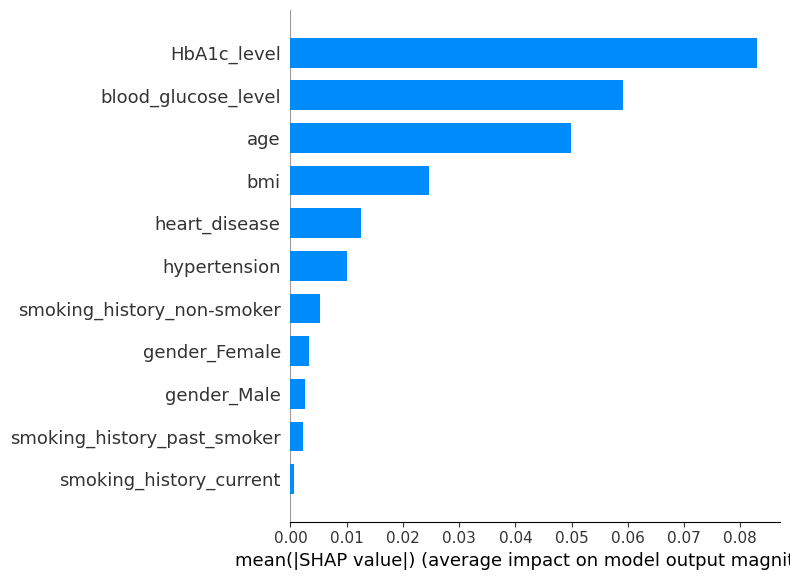

In [3]:

shap.summary_plot(shap_values[1], X_test_transformed_df, plot_type="bar", title="SHAP Global Feature Importance")

### SHAP Local

--- Explaining Patient (Index: 59547) ---
Original Patient Data:
gender                    Male
age                       70.0
hypertension                 0
heart_disease                0
smoking_history        current
bmi                      29.01
HbA1c_level                7.5
blood_glucose_level        140
Name: 59547, dtype: object

SHAP Force Plot (Local Explanation):


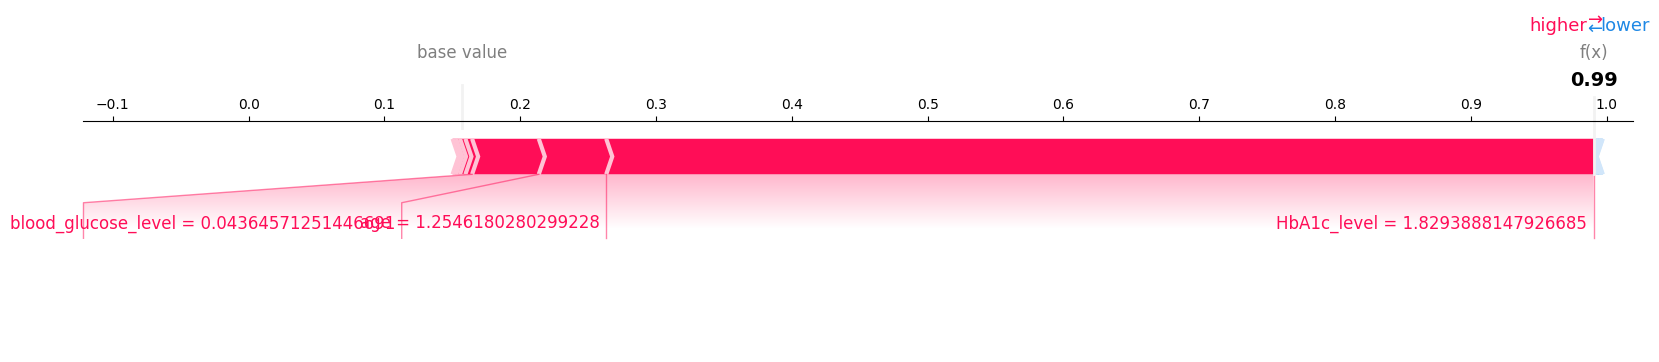

None

In [4]:
# Find a specific patient to explain

true_positives_idx = X_test[(y_test == 1) & (y_pred == 1)].index
if len(true_positives_idx) > 0:
    patient_index = true_positives_idx[0] # Get the first one
    patient_loc = X_test.index.get_loc(patient_index) # Get the integer row location

    print(f"--- Explaining Patient (Index: {patient_index}) ---")
    

    print("Original Patient Data:")
    print(X_test.loc[patient_index])
    

    print("\nSHAP Force Plot (Local Explanation):")
    
    # shap.initjs() # Uncomment this if in a classic Jupyter Notebook
    
    display(shap.force_plot(explainer.expected_value[1], 
                            shap_values[1][patient_loc, :], 
                            X_test_transformed_df.iloc[patient_loc, :],
                            matplotlib=True)) # Use matplotlib=True for Kaggle/non-notebooks
else:
    print("Could not find a True Positive patient in the test set to explain.")

## COUNTERFACTUALS 

In [26]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

patient_index = 49172

MAX_REDUCTION_PERCENT = 0.90
MAX_INCREASE_PERCENT = 0.90

print("--- Initializing Manual Counterfactual Explainer ---")

if 'patient_index' in locals():
    if patient_index not in X_test.index:
        display(Markdown(f"### <span style='color:red;'>Error: Patient ID {patient_index} not found in the test set.</span>"))
        display(Markdown(f"Please choose an ID from the list printed at the end of your notebook."))
    
    else:
        original_patient_raw = X_test.loc[patient_index:patient_index]
        original_prediction = best_model.predict(original_patient_raw)[0]
        
        if original_prediction == 0:
            display(Markdown(f"### <span style='color:orange;'>⚠️ Warning</span>"))
            display(Markdown(f"Patient (Index: {patient_index}) is already predicted 'No Diabetes' (0)."))
            display(Markdown("Please choose a patient ID that was predicted as 'Diabetes' (1)."))
        
        else:
            display(Markdown(f"### 🩺 Original Patient Analysis (Index: {patient_index})"))
            display(Markdown(f"**Original Prediction: <span style='color:red;font-weight:bold;'>1 (Diabetes)</span>**"))
            print("\nOriginal Patient Data:")
            print(original_patient_raw)
            
            features_to_test = ['HbA1c_level', 'blood_glucose_level', 'bmi', 'age']
            all_counterfactuals = []

            display(Markdown("---")) 
            display(Markdown(f"### ⚙️ Finding All Counterfactuals..."))
            print(f"Testing features (up to {MAX_REDUCTION_PERCENT * 100:.0f}% decrease and {MAX_INCREASE_PERCENT * 100:.0f}% increase):")

            for feature in features_to_test:
                print(f"  - Testing feature: {feature}...")
                original_value = original_patient_raw[feature].iloc[0]
                

                feature_cf_found_decrease = False
                for reduction_percent in np.linspace(0.01, MAX_REDUCTION_PERCENT, 100):
                    new_patient = original_patient_raw.copy()
                    new_value = original_value * (1 - reduction_percent)
                    new_patient[feature] = new_value
                    new_prediction = best_model.predict(new_patient)[0]
                    
                    if new_prediction == 0:
                        cf_result = {
                            'Feature': feature,
                            'Original Value': f"{original_value:.2f}",
                            'Change': 'Decrease',
                            'Required Value (to flip to 0)': f"{new_value:.2f}"
                        }
                        all_counterfactuals.append(cf_result)
                        print(f"    ... ✅ Success (Decrease)! Flip found at {new_value:.2f}")
                        feature_cf_found_decrease = True
                        break 
                
                if not feature_cf_found_decrease:
                    print(f"    ... ❌ No counterfactual found for '{feature}' by decreasing.")


                feature_cf_found_increase = False
                for increase_percent in np.linspace(0.01, MAX_INCREASE_PERCENT, 100):
                    new_patient = original_patient_raw.copy()
                    new_value = original_value * (1 + increase_percent)
                    new_patient[feature] = new_value
                    new_prediction = best_model.predict(new_patient)[0]

                    if new_prediction == 0:
                        cf_result = {
                            'Feature': feature,
                            'Original Value': f"{original_value:.2f}",
                            'Change': 'Increase',
                            'Required Value (to flip to 0)': f"{new_value:.2f}"
                        }
                        all_counterfactuals.append(cf_result)
                        print(f"    ... ✅ Success (Increase)! Flip found at {new_value:.2f}")
                        feature_cf_found_increase = True
                        break

                if not feature_cf_found_increase and feature != 'age': # 'age' typically can't be increased to prevent diabetes
                    print(f"    ... ❌ No counterfactual found for '{feature}' by increasing.")
                elif not feature_cf_found_increase and feature == 'age':
                     print(f"    ... (Skipping 'increase' test for 'age')")



            if not all_counterfactuals:
                display(Markdown("---"))
                display(Markdown(f"### ℹ️ No Simple Counterfactual Found"))
                display(Markdown(f"Could not find a counterfactual within the specified limits."))
                display(Markdown("The model's 'Diabetes' prediction for this patient is very strong."))
            
            else:
                display(Markdown("---")) 
                display(Markdown(f"### ✅ Final Results: All Counterfactuals"))
                display(Markdown(f"To change the prediction to **<span style='color:green;font-weight:bold;'>0 (No Diabetes)</span>**, the model suggests any of the following minimum changes:"))
                
                cf_df = pd.DataFrame(all_counterfactuals)
                cf_df = cf_df.set_index('Feature')
                print(cf_df)
else: 
    display(Markdown(f"### <span style='color:red;'>Error: 'patient_index' not found.</span>"))
    display(Markdown("This can happen on a notebook restart. Please define variables at the top of this cell."))

--- Initializing Manual Counterfactual Explainer ---


### 🩺 Original Patient Analysis (Index: 49172)

**Original Prediction: <span style='color:red;font-weight:bold;'>1 (Diabetes)</span>**


Original Patient Data:
      gender   age  hypertension  heart_disease smoking_history    bmi  \
49172   Male  59.0             1              0     past_smoker  28.24   

       HbA1c_level  blood_glucose_level  
49172          6.6                  140  


---

### ⚙️ Finding All Counterfactuals...

Testing features (up to 90% decrease and 90% increase):
  - Testing feature: HbA1c_level...
    ... ✅ Success (Decrease)! Flip found at 5.35
    ... ❌ No counterfactual found for 'HbA1c_level' by increasing.
  - Testing feature: blood_glucose_level...
    ... ✅ Success (Decrease)! Flip found at 112.17
    ... ❌ No counterfactual found for 'blood_glucose_level' by increasing.
  - Testing feature: bmi...
    ... ❌ No counterfactual found for 'bmi' by decreasing.
    ... ❌ No counterfactual found for 'bmi' by increasing.
  - Testing feature: age...
    ... ✅ Success (Decrease)! Flip found at 50.98
    ... (Skipping 'increase' test for 'age')


---

### ✅ Final Results: All Counterfactuals

To change the prediction to **<span style='color:green;font-weight:bold;'>0 (No Diabetes)</span>**, the model suggests any of the following minimum changes:

                    Original Value    Change Required Value (to flip to 0)
Feature                                                                   
HbA1c_level                   6.60  Decrease                          5.35
blood_glucose_level         140.00  Decrease                        112.17
age                          59.00  Decrease                         50.98


In [8]:
# Find other patients predicted as 'Diabetes' (1)
diabetes_patient_indices = X_test[y_pred == 1].index

print("Use any of these Patient IDs for your next test:")
print(diabetes_patient_indices.tolist()[:10])

Use any of these Patient IDs for your next test:
[49172, 59547, 84239, 6785, 91127, 37029, 87451, 62412, 92133, 26732]
